numFeatures 10
val acc 0.848
train acc 0.8655913978494624
y_pred [1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0.]
y_true 110    1.0
147    1.0
494    0.0
325    1.0
189    0.0
      ... 
41     1.0
382    0.0
285    1.0
412    0.0
289    0.0
Name: target, Length: 125, dtype: float64
[0.848]


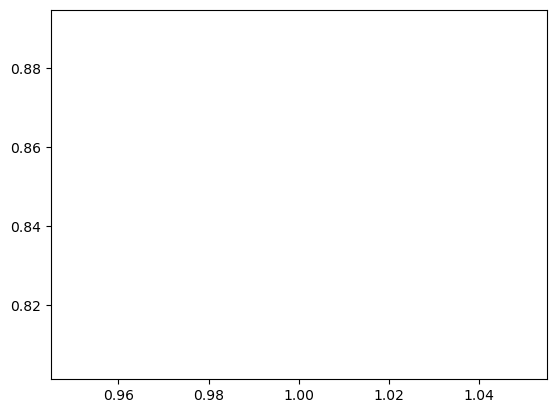

In [21]:
from parsingGrowthCurveFiles import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.neural_network import *
# import shap
import os
# import xgboost as xgb


debug = False
def createDataset(targets,alignedSnpsAsDict,alignedSnpIndexes, outFileName, significantSnpData, onlySigSnps=True, onlyLastTimePoint=False):
	data = []
	if onlySigSnps:
		indexInSnpGenomeOfSigSnps = []
		sigSnpGenomePoses = getSignificantSnpIndexes(significantSnpData)
		sigSnpGenomePoses.sort(key=lambda a: a[0] + a[1])
		indexOfNextSigSnpGenomePos = 0
		i = 0
		sigSnpGenomePosesAdded = []
		for genomePos in alignedSnpIndexes:
			if indexOfNextSigSnpGenomePos == len(sigSnpGenomePoses):
				break
			if int(genomePos) == sigSnpGenomePoses[indexOfNextSigSnpGenomePos][0] + sigSnpGenomePoses[indexOfNextSigSnpGenomePos][1]:# sigSnpGenomePoses[max(indexOfNextSigSnpGenomePos-20,0):indexOfNextSigSnpGenomePos+20]:
				sigSnpGenomePosesAdded.append("geneStart_" + str(sigSnpGenomePoses[indexOfNextSigSnpGenomePos][0]) + "Index_" +  str(sigSnpGenomePoses[indexOfNextSigSnpGenomePos][1]))
				indexOfNextSigSnpGenomePos += 1
				indexInSnpGenomeOfSigSnps.append(i)
				
			elif int(genomePos) > sigSnpGenomePoses[indexOfNextSigSnpGenomePos][0] + sigSnpGenomePoses[indexOfNextSigSnpGenomePos][1]: # skip if didn't find it
				indexOfNextSigSnpGenomePos += 1
			i += 1
		if indexOfNextSigSnpGenomePos != len(sigSnpGenomePoses):
			# raise Exception("problem")
			print(indexOfNextSigSnpGenomePos, "idex of next snp isn't len(sigSnpGenomePoses)", len(sigSnpGenomePoses))
		
		header = "\t".join(["fileName", "target"] + [str(idx) for idx in sigSnpGenomePosesAdded])
		i = -1
		if debug:
			print("targets keys", targets.keys())
			
		for key, val in alignedSnpsAsDict.items():
			i += 1
			snpsToAdd = []
			val = val.strip()
			for idx in indexInSnpGenomeOfSigSnps:
				# print("snps", val[idx])
				snpsToAdd.append(val[idx])
			try:
				data.append(key + "\t" + str(targets[key]) + "\t" + "\t".join(
				snpsToAdd)) 
				
			except KeyError:
				if debug:
					print("didn't find", key)
	else:
		header = "\t".join(["fileName", "target"] + [str(idx) for idx in alignedSnpIndexes])
		
		for key,val in alignedSnpsAsDict.items():
			try:
				data.append(key + "\t" + str(targets[key]) + "\t" + "\t".join(
				snpsToAdd)) 
				# need to only consider significant aleles but maybe at firsta can just do all of them
			except KeyError:
				if debug:
					print("didn't find",key)
		
	with open(outFileName, "w") as outFile:
		outFile.write(header + "\n")
		for line in data:
			outFile.write(line + "\n")

def trainAndRunShap(dataset): # pandas
	dataset.pop("fileName")
	y = dataset.pop("target").astype(float)
	
	X:pd.DataFrame = pd.get_dummies(dataset)
	valAccs = []
	for numFeatures in range(10,11):
		print("numFeatures", numFeatures)
		reducedFeatures = ['geneStart_2848875Index_1151_T','geneStart_46478Index_-16_A', 'geneStart_46478Index_-16_G', 'geneStart_4617494Index_1329_G', 'geneStart_4617494Index_1329_T', 'geneStart_2848875Index_1151_G', 'geneStart_273987Index_-2105_A', 'geneStart_273987Index_-2105_G', 'geneStart_46478Index_-138_A', 'geneStart_46478Index_-141_C', 'geneStart_46478Index_-138_G', 'geneStart_46478Index_-141_T', 'geneStart_1611762Index_2781_C', 'geneStart_1611762Index_2781_T', 'geneStart_798261Index_1209_G', 'geneStart_1611762Index_2783_G', 'geneStart_4713593Index_1990_A', 'geneStart_798261Index_1203_T', 'geneStart_4713593Index_1994_G', 'geneStart_4713593Index_1994_T', 'geneStart_1611762Index_2780_T', 'geneStart_798261Index_1209_A', 'geneStart_1981205Index_1164_A', 'geneStart_1611762Index_2783_A', 'geneStart_4713593Index_1987_C', 'geneStart_4713593Index_1990_-', 'geneStart_4740524Index_610_G', 'geneStart_1611762Index_2784_G', 'geneStart_1611762Index_2780_C', 'geneStart_798261Index_1203_C', 'geneStart_1610901Index_60_A', 'geneStart_1611762Index_2784_A', 'geneStart_1981205Index_1164_T', 'geneStart_4624378Index_-37_C', 'geneStart_3077707Index_-227_G', 'geneStart_4713593Index_1987_T', 'geneStart_4713593Index_912_G', 'geneStart_4200127Index_909_G', 'geneStart_2571573Index_318_G', 'geneStart_4740524Index_610_C', 'geneStart_4715665Index_-35_C', 'geneStart_4624378Index_-37_T', 'geneStart_4200127Index_909_T', 'geneStart_511450Index_180_A', 'geneStart_1269572Index_1062_G', 'geneStart_4715665Index_-35_A', 'geneStart_511450Index_180_G', 'geneStart_4713593Index_1410_A', 'geneStart_3077707Index_-227_A', 'geneStart_1610901Index_60_T', 'geneStart_1981205Index_1169_A', 'geneStart_1981205Index_1169_C', 'geneStart_4713593Index_912_A', 'geneStart_4717102Index_1014_T', 'geneStart_4717102Index_1014_A', 'geneStart_1269572Index_1062_A', 'geneStart_2571573Index_321_G', 'geneStart_4713593Index_1414_A', 'geneStart_4690801Index_272_C', 'geneStart_4713593Index_1944_T', 'geneStart_1981205Index_1168_T', 'geneStart_133954Index_1904_C', 'geneStart_748777Index_587_C', 'geneStart_1981205Index_223_G', 'geneStart_4690801Index_272_T', 'geneStart_2571573Index_339_T', 'geneStart_2136000Index_275_C', 'geneStart_1981205Index_1168_C', 'geneStart_4713593Index_1414_G', 'geneStart_748777Index_587_T', 'geneStart_2571573Index_349_T', 'geneStart_2571573Index_339_G']
		X_reduced = X[reducedFeatures[:numFeatures]]

		train_X, val_X, train_y, val_y = train_test_split(X_reduced, y, random_state=1)
		# Xd = xgboost.DMatrix(X, label=y)
		# model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

		# print("Model error =", np.linalg.norm(y - model.predict(Xd)))
		# print(model.get_dump(with_stats=True)[0])
		rfClass = RandomForestClassifier(n_estimators=1000).fit(train_X,train_y)
		rowToShow = 6
		# explainer = shap.TreeExplainer(rfClass)
		# Calculate Shap values
		# shap_values = explainer.shap_values(val_X)

		# vals= np.abs(shap_values).mean(0)

		# feature_importance = pd.DataFrame(list(zip(X.columns, shap_values)), columns=['col_name','feature_importance_vals'])
		# feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
		# feature_importance.head()
		# if debug:
			# print("Expected Value:", explainer.expected_value)
		# 	print("SHAP Values:", shap_values)
		# 	print("sv",len(shap_values))
		valAcc = (rfClass.predict(val_X) == val_y).mean()
		print("val acc", valAcc)
		print("train acc", (rfClass.predict(train_X) == train_y).mean())
		# print("val MAE", sum(abs(rfClass.predict(val_X) - val_y)) / len(val_y))
		valAccs.append(valAcc)
		# print("train MAE", sum(abs(rfClass.predict(train_X) - train_y)) / len(train_y))
		print("y_pred", rfClass.predict(val_X))
		print("y_true", val_y)
		print(valAccs)
	plt.plot([i for i in range(1,len(valAccs)+1)],valAccs)
	plt.show()
	# shap.initjs()
	# # shap.force_plot(explainer.expected_value[1], shap_values[:,1], data_for_prediction)
	# shap.summary_plot(shap_values,val_X, max_display=200)
	# plt.savefig("summaryPlot.png", format="png")
	# plt.close()
	return rfClass
	
def getSignificantSnpIndexes(significantSnpData, pValueCutoff=1e-20):
	idxs = []
	firstLine = True
	for line in significantSnpData:
		if firstLine:
			firstLine = False
			continue
		cols = line.split('\t')
		geneStartPos = int(cols[11])
		unCorrectedIndexWithinGene = int(cols[2])
		snpName = cols[4] + cols[2]
		pvalue = float(cols[0])
		if pvalue < pValueCutoff:
			if debug:
				print(pvalue,geneStartPos + unCorrectedIndexWithinGene)
			idxs.append([geneStartPos, unCorrectedIndexWithinGene])
	return idxs
if __name__ == "__main__":
	
	alignedSnpsPath = "/Users/cazcullimore/dev/ericksonLabCode/ScaffoldFromAssembly/bovineSelfScaffold.afa"
	alignedIndexPath = "/Users/cazcullimore/dev/ericksonLabCode/ScaffoldFromAssembly/bovineSelfScaffoldIndexes.txt"

	targets = {key + ".vcf": 1 if val[1] == "pathogen" else 0 for key,val in readMetaDataAsDict("/Users/cazcullimore/dev/data/metaDataForMetaCatsWithExtraMastitisWithoutScaffoldNames.tsv").items()}
	# print(len(list(targets.keys())))
	datasetPath = "/Users/cazcullimore/dev/data/dataForRFMastitisCommensal.tsv"
	# if not os.path.exists(datasetPath):
	with open("/Users/cazcullimore/dev/ericksonLabCode/ScaffoldFromAssembly/snpsSortedBySignificanceWithGenesContainingThembovineSelfScaffoldPathogenicity.tsv") as file:
		sigSnpData = file.readlines()
		createDataset(targets, readInFastaAsDict(alignedSnpsPath), readIndexes(alignedIndexPath), datasetPath, significantSnpData=sigSnpData, onlyLastTimePoint=False)
	# else:
	# 	print("found dataset file using that")
	rfClass = trainAndRunShap(pd.read_csv(datasetPath, delimiter='\t'))
	"""50 features 
	val MSE 0.0024660483365868285
train MSE 0.00045887003507715267
val MAE 0.024247464402395016
train MAE 0.009662864379214084"""

In [ ]:
rfClass

In [ ]:
explainer = shap.TreeExplainer(rfClass)
dataset = pd.read_csv(datasetPath, delimiter='\t')
dataset.pop("fileName")
y = dataset.pop("target").astype(float)

X:pd.DataFrame = pd.get_dummies(dataset)
valAcc = []
for numFeatures in range(1,2):
    print("numFeatures", numFeatures)
    X_reduced = X#[reducedFeatures[:numFeatures]]

    train_X, val_X, train_y, val_y = train_test_split(X_reduced, y, random_state=1)
# Calculate Shap values
shap_values = explainer.shap_values(val_X)

# vals= np.abs(shap_values).mean(0)

# feature_importance = pd.DataFrame(list(zip(X.columns, shap_values)), columns=['col_name','feature_importance_vals'])
# feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
# feature_importance.head()
if debug:
    print("Expected Value:", explainer.expected_value)
    print("SHAP Values:", shap_values)
    print("sv",len(shap_values))
# print("val acc", (rfClass.predict(val_X) == val_y).mean())
# print("train acc", (rfClass.predict(train_X) == train_y).mean())
print("val MSE", sum((rfClass.predict(val_X) - val_y)**2) / len(val_y))
print("train MSE", sum((rfClass.predict(train_X) - train_y)**2) / len(train_y))
print("val MAE", sum(abs(rfClass.predict(val_X) - val_y)) / len(val_y))
print("train MAE", sum(abs(rfClass.predict(train_X) - train_y)) / len(train_y))
print("y_pred", rfClass.predict(val_X))
print("y_true", val_y)
shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[:,1], data_for_prediction)
shap.summary_plot(shap_values,val_X, max_display=200)
plt.savefig("summaryPlot.png", format="png")
plt.close()

In [17]:
print("shap shape",shap_values[1].shape)
print("val shape",val_X.shape)
print(abs(shap_values[1]).sum(0).shape)
val_X.head()
namesAndShap = [(name,val) for name, val in zip(val_X.columns, abs(shap_values[1]).sum(0))]
namesAndShap.sort(key=lambda a: -a[1])
numFeaturesToGet = 80
print([name for name, val in namesAndShap][:numFeaturesToGet])
# print(namesAndShap)

shap shape (125, 2051)
val shape (125, 2051)
(2051,)
['geneStart_4616454Index_675_G', 'geneStart_4621757Index_796_A', 'geneStart_4616454Index_675_A', 'geneStart_4621757Index_796_G', 'geneStart_4617494Index_567_G', 'geneStart_4617494Index_567_A', 'geneStart_2848875Index_1151_T', 'geneStart_4619863Index_21_C', 'geneStart_4619863Index_21_G', 'geneStart_46478Index_-16_A', 'geneStart_46478Index_-16_G', 'geneStart_4617494Index_1329_G', 'geneStart_4617494Index_1329_T', 'geneStart_2848875Index_1151_G', 'geneStart_273987Index_-2105_A', 'geneStart_273987Index_-2105_G', 'geneStart_46478Index_-138_A', 'geneStart_46478Index_-141_C', 'geneStart_46478Index_-138_G', 'geneStart_46478Index_-141_T', 'geneStart_1611762Index_2781_C', 'geneStart_1611762Index_2781_T', 'geneStart_798261Index_1209_G', 'geneStart_1611762Index_2783_G', 'geneStart_4713593Index_1990_A', 'geneStart_798261Index_1203_T', 'geneStart_4713593Index_1994_G', 'geneStart_4713593Index_1994_T', 'geneStart_1611762Index_2780_T', 'geneStart_7982

In [25]:
features = ['geneStart_2848875Index_1151_T','geneStart_46478Index_-16_A', 'geneStart_46478Index_-16_G', 'geneStart_4617494Index_1329_G', 'geneStart_4617494Index_1329_T', 'geneStart_2848875Index_1151_G', 'geneStart_273987Index_-2105_A', 'geneStart_273987Index_-2105_G', 'geneStart_46478Index_-138_A','geneStart_46478Index_-141_C', 'geneStart_46478Index_-138_G', 'geneStart_46478Index_-141_T', 'geneStart_1611762Index_2781_C', 'geneStart_1611762Index_2781_T', 'geneStart_798261Index_1209_G', 'geneStart_1611762Index_2783_G', 'geneStart_4713593Index_1990_A', 'geneStart_798261Index_1203_T', 'geneStart_4713593Index_1994_G', 'geneStart_4713593Index_1994_T', 'geneStart_1611762Index_2780_T', 'geneStart_798261Index_1209_A', 'geneStart_1981205Index_1164_A', 'geneStart_1611762Index_2783_A', 'geneStart_4713593Index_1987_C', 'geneStart_4713593Index_1990_-', 'geneStart_4740524Index_610_G', 'geneStart_1611762Index_2784_G', 'geneStart_1611762Index_2780_C', 'geneStart_798261Index_1203_C', 'geneStart_1610901Index_60_A', 'geneStart_1611762Index_2784_A', 'geneStart_1981205Index_1164_T', 'geneStart_4624378Index_-37_C', 'geneStart_3077707Index_-227_G', 'geneStart_4713593Index_1987_T', 'geneStart_4713593Index_912_G', 'geneStart_4200127Index_909_G', 'geneStart_2571573Index_318_G', 'geneStart_4740524Index_610_C', 'geneStart_4715665Index_-35_C', 'geneStart_4624378Index_-37_T', 'geneStart_4200127Index_909_T', 'geneStart_511450Index_180_A', 'geneStart_1269572Index_1062_G', 'geneStart_4715665Index_-35_A', 'geneStart_511450Index_180_G', 'geneStart_4713593Index_1410_A', 'geneStart_3077707Index_-227_A', 'geneStart_1610901Index_60_T', 'geneStart_1981205Index_1169_A', 'geneStart_1981205Index_1169_C', 'geneStart_4713593Index_912_A', 'geneStart_4717102Index_1014_T', 'geneStart_4717102Index_1014_A', 'geneStart_1269572Index_1062_A', 'geneStart_2571573Index_321_G', 'geneStart_4713593Index_1414_A', 'geneStart_4690801Index_272_C', 'geneStart_4713593Index_1944_T', 'geneStart_1981205Index_1168_T', 'geneStart_133954Index_1904_C', 'geneStart_748777Index_587_C', 'geneStart_1981205Index_223_G', 'geneStart_4690801Index_272_T', 'geneStart_2571573Index_339_T', 'geneStart_2136000Index_275_C', 'geneStart_1981205Index_1168_C', 'geneStart_4713593Index_1414_G', 'geneStart_748777Index_587_T', 'geneStart_2571573Index_349_T', 'geneStart_2571573Index_339_G']
def getSignificantSnpNames(significantSnpData, featureNames, pValueCutoff=1e-20):
	idxs = []
	
	for name in featureNames:
		firstLine = True
		for line in significantSnpData:
			if firstLine:
				firstLine = False
				continue
			cols = line.split('\t')
			geneStartPos = int(cols[11])
			unCorrectedIndexWithinGene = int(cols[2])
			snpName = cols[4] + cols[2]
			pvalue = float(cols[0])
			if pvalue < pValueCutoff:
					if str(geneStartPos) in name and cols[2] in name:
						print(name, cols[4], cols[2])

with open("/Users/cazcullimore/dev/ericksonLabCode/ScaffoldFromAssembly/snpsSortedBySignificanceWithGenesContainingThembovineSelfScaffoldPathogenicity.tsv") as file:
		sigSnpData = file.readlines()
		getSignificantSnpNames(significantSnpData=sigSnpData, featureNames=features[:10])

geneStart_2848875Index_1151_T gadB 1151
geneStart_46478Index_-16_A NearestGeneIs:murI -16
geneStart_46478Index_-16_G NearestGeneIs:murI -16
geneStart_4617494Index_1329_G fecA 1329
geneStart_4617494Index_1329_T fecA 1329
geneStart_2848875Index_1151_G gadB 1151
geneStart_273987Index_-2105_A NearestGeneIs:nanR_1 -2105
geneStart_273987Index_-2105_G NearestGeneIs:nanR_1 -2105
geneStart_46478Index_-138_A NearestGeneIs:murI -138
geneStart_46478Index_-141_C NearestGeneIs:murI -141


RandomForestClassifier(n_estimators=1000)